In [1]:
#Load necessary packages
import pandas as pd
import os
import numpy as np
import copy

import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

### Data Prep - all code condensed from Library_Week2_Notebook4_Strategy#2

In [2]:
##CODE FROM NOTEBOOK: Library_Week2_Notebook4_Strategy#2
#(Load and process data created in Library_Week2_Notebook4_Strategy#2)

#Load data
os.chdir("//Users/Olga/Documents/INSIGHT2019/Library data/AllPldData")
Files_in_folder = os.listdir()
File_names = ['_2014', '_2015', '_2016', '_2001', '_2002', '_2003', 
              '_2004','_2005', '_2006', '_2007', '_2008', '_2009', 
              '_2010', '_2011', '_2012', '_2013', '_2000', '_1992', 
              '_1993', '_1994', '_1995', '_1996', '_1997', '_1998', '_1999']
Files = []

for filename in os.listdir():
    if filename.endswith('csv'):
        Files.append(pd.read_csv(filename, encoding = 'latin-1', low_memory = False))
        
#create dictionary of libraries labeled by year
LibData_dict = {}
for i in range(0, len(File_names)):
    LibData_dict[File_names[i]] = Files[i]
    
for k, v in LibData_dict.items():
    print(k, v.shape, type(LibData_dict[k]))

ColumnsPresent = pd.DataFrame(index=range(0),columns=range(0))

for k, v in LibData_dict.items():
    dataframe_to_join = pd.DataFrame({k: list(v.columns)})
    ColumnsPresent = ColumnsPresent.join(dataframe_to_join, how = 'outer')

#Rearrange columns in dataframe. 
cols = ColumnsPresent.columns.tolist()
cols_rearr = cols[17:] + cols[0:17]
cols_rearr2 = cols_rearr[0:8] + cols_rearr[24:25] + cols_rearr[11:24] + cols_rearr[8:11]

ColumnsPresent_rearr = ColumnsPresent[cols_rearr2]

ColumnsPresent_rearr_str = ColumnsPresent_rearr.applymap(str)
ColumnsPresent_rearr_str = ColumnsPresent_rearr_str.reset_index(drop = True)

#create DF of unique column values
UniqueLabels = np.unique(ColumnsPresent_rearr_str.values)
LabelsBoolDF = pd.DataFrame(UniqueLabels)

#Create DF w boolean values for prensence of each unique value
#THIS IS THE END GOAL OF THIS DATA
for j in range(len(ColumnsPresent_rearr_str.columns)):
    lis = []
    for i in range(len(UniqueLabels)):
        lis.append(ColumnsPresent_rearr_str.iloc[:, j].isin([UniqueLabels[i]]).any())
    LabelsBoolDF[ColumnsPresent_rearr_str.columns[j]] = lis
    
## Sum all TRUE values. Value of 25 = all true
sum_list = []
for i in range(LabelsBoolDF.shape[0]):
    sum_list.append(sum(LabelsBoolDF.iloc[i, 1:26]))

#Label OK in Notes
LabelsBoolDF['TRUE SUM'] = sum_list
LabelsBoolDF['Notes'] = ""
LabelsBoolDF.loc[LabelsBoolDF[LabelsBoolDF['TRUE SUM']==25].index, 'Notes'] = "OK"

#rows in which not all TRUE (meaning this column/data does not exist for all year)
MissingData = LabelsBoolDF[LabelsBoolDF['TRUE SUM']!=25].index.tolist()

#Column names to keep
#LabelsBoolDF.loc[[0, 3:13, 15], 0].tolist()
Cols_to_keep_idx = [0]
Cols_to_keep_idx.extend(range(3,13))
Cols_to_keep_idx.extend((16, 18, 20, 25, 26))
Cols_to_keep_idx.extend(range(33, 49))
Cols_to_keep_idx.extend((64, 135, 137, 138, 183))
Cols_to_keep_idx.extend(range(185, 189))
Cols_to_keep_idx.extend(range(191, 199))
Cols_to_keep_idx.append(201)
Cols_to_keep_idx.extend(range(206, 219))
Cols_to_keep_idx.append(220)
Cols_to_keep_idx.extend(range(222, 229))
Cols_to_keep_idx.extend((230, 231, 237))
Cols_to_keep_idx.extend(range(237, 256))
Cols_to_keep_idx.extend(range(257, 260))
Cols_to_keep_idx.extend((262, 263))

Cols_to_keep_in_lib_dfs = LabelsBoolDF.iloc[Cols_to_keep_idx, 0].tolist()

#Make dictionaries of smaller dataframe with Cols_to_keep_in_lib_dfs ONLY
LibData_dict_reduced = dict()

for k, v in LibData_dict.items():
    LibData_dict_reduced[k] = pd.DataFrame()
    for i in Cols_to_keep_in_lib_dfs:
        if i in v:
            TempList = list(v[i])
            LibData_dict_reduced[k][i] = TempList

#Did above loop do what I thought it did?
print("Original dfs:")
for k, v in LibData_dict.items():
    print(k, v.shape)

print("\n", "Reduced dfs:")  
for k, v in LibData_dict_reduced.items():    
    print(k, v.shape)

#Combine col names that mean same thing in different years into single 
Names_to_combine = ["ATTEND", "VISITS",  "C_LEGBAS", "C_LEGBASE", "DUPLI", "HRS_OPEN", "KIDATTEN", "KIDATTEND", 
                    "LIBRARIAN", "LIBRARIA", "POPU", "POPU_LSA", "POPU_UND", "POPU_UNDUP", "REFERENC", "REFERENCE", 
                    "STAFFEXP", "TOTEXP", "SUBSCRIP", "SUBSCRIPT", "TOTEXPCO", "TOTEXPCOL", 
                    "TOTOPEXP", "TOTOPEXP1", "TOTPEMP", "TOTSTAFF", "ZIP", "ZIP1"]

for i in range(0, len(Names_to_combine)-1, 2):
    for k, v in LibData_dict_reduced.items(): 
        if Names_to_combine[i] in v:
            name = Names_to_combine[i]
            newname = Names_to_combine[i] + "-" + Names_to_combine[i+1]
            v = v.rename(columns = {name: newname}, inplace = True)
        elif Names_to_combine[i+1] in v:
            name = Names_to_combine[i + 1]
            newname = Names_to_combine[i] + "-" + Names_to_combine[i+1]
            v = v.rename(columns = {name : newname}, inplace = True)

#Check that above code worked - names changes
for k, v in LibData_dict_reduced.items():
    print(v.columns)

for k, v in LibData_dict_reduced.items():    
    print(k, v.shape)

#Columns to add to DFs
"AUDIO is divided into AUDIO_PH, AUDIO_DL starting 2010. Source: 2010 Documentation."
"VIDEO was later split into VIDEO_DL and VIDEO_PH."

for k, v in LibData_dict_reduced.items(): 
    if "AUDIO_DL" in v:
        v["AUDIO"] = v['AUDIO_DL'] + v['AUDIO_PH']
    if "VIDEO_DL" in v:
        v["VIDEO"] = v['VIDEO_DL'] + v['VIDEO_PH']

#Check that # columns in some dataframes increased by 2 (expected)
for k, v in LibData_dict_reduced.items():    
    print(k, v.shape)
    
#Create DF w boolean values for prensence of each unique value in REDUCED dataframes
#THIS IS THE END GOAL OF THIS DATA

#Get all unique columns present in LibData_dict_reduced dataframes. 
ColumnsPresent_reduced = pd.DataFrame(index=range(0),columns=range(0))

for k, v in LibData_dict_reduced.items():
    dataframe_to_join_reduced = pd.DataFrame({k: list(v.columns)})
    ColumnsPresent_reduced = ColumnsPresent_reduced.join(dataframe_to_join_reduced, how = 'outer')

ColumnsPresent_reduced_str = ColumnsPresent_reduced.applymap(str)
ColumnsPresent_reduced_str = ColumnsPresent_reduced_str.reset_index(drop = True)
    
UniqueLabels_reduced = np.unique(ColumnsPresent_reduced_str.values)
LabelsBoolDF_reduced = pd.DataFrame(UniqueLabels_reduced)

#Create DF w boolean values for prensence of each unique value
#THIS IS THE END GOAL OF THIS DATA
for j in range(len(ColumnsPresent_reduced_str.columns)):
    lis = []
    for i in range(len(UniqueLabels_reduced)):
        lis.append(ColumnsPresent_reduced_str.iloc[:, j].isin([UniqueLabels_reduced[i]]).any())
    LabelsBoolDF_reduced[ColumnsPresent_reduced_str.columns[j]] = lis

## Sum all TRUE values. Value of 25 = all true
sum_list_reduced = []
for i in range(LabelsBoolDF_reduced.shape[0]):
    sum_list_reduced.append(sum(LabelsBoolDF_reduced.iloc[i, 1:26]))

#Label OK in Notes
LabelsBoolDF_reduced['TRUE SUM'] = sum_list_reduced
LabelsBoolDF_reduced['Notes'] = ""
LabelsBoolDF_reduced.loc[LabelsBoolDF_reduced[LabelsBoolDF_reduced['TRUE SUM']==25].index, 'Notes'] = "OK"

All_Cols_in_Reduced_dfs = list(LabelsBoolDF_reduced[0])
All_Cols_in_Reduced_dfs

for k, v in LibData_dict_reduced.items():    
    print(k, v.shape)
    
#Delete columns deemed NOT useful for downstream analysis
NonUsefulColstoDelete = ['ENDDATE', 'LIBID', 'PHONE', 'POPU_UND-POPU_UNDUP', 'RSTATUS', 'TOTCOLL', 'ZIP-ZIP1']

LibData_dict_reduced_dropuseless = copy.deepcopy(LibData_dict_reduced)

for k, v in LibData_dict_reduced_dropuseless.items(): 
    for i in range(len(NonUsefulColstoDelete)):
        if NonUsefulColstoDelete[i] in v:
            v.drop([NonUsefulColstoDelete[i]], axis = 1, inplace = True)
            
#Check quickly whether columns were dropped
print("Reduced dfs:")
for k, v in LibData_dict_reduced.items():    
    print(k, v.shape)

print("\n", "Reduced and dropped useless dfs:")
for k, v in LibData_dict_reduced_dropuseless.items():    
    print(k, v.shape)

#Get rid of negative values (replace w NaN)
#For all DFs, replace (-1, -3, -9) values with NaN. 
LibData_dict_reduced_dropuseless_NegRepWNaN = copy.deepcopy(LibData_dict_reduced_dropuseless)

for k, v in LibData_dict_reduced_dropuseless_NegRepWNaN.items():
    v[(v == -1) | (v == -3) | (v == -9)] = np.nan
    
#See if this worked (looks like it did)
print(sum(LibData_dict_reduced_dropuseless['_2014']['AUDIO_DL'] < 0))
print(np.where((LibData_dict_reduced_dropuseless['_2014']['AUDIO_DL'] < 0) == True))

print(sum(LibData_dict_reduced_dropuseless_NegRepWNaN['_2014']['AUDIO_DL'].isnull()))
print(np.where(LibData_dict_reduced_dropuseless_NegRepWNaN['_2014']['AUDIO_DL'].isnull()))

for k, v in LibData_dict_reduced_dropuseless_NegRepWNaN.items():
    print(k, v.shape)
    


_2014 (9305, 159) <class 'pandas.core.frame.DataFrame'>
_2015 (9251, 159) <class 'pandas.core.frame.DataFrame'>
_2016 (9252, 151) <class 'pandas.core.frame.DataFrame'>
_2001 (9133, 108) <class 'pandas.core.frame.DataFrame'>
_2002 (9141, 107) <class 'pandas.core.frame.DataFrame'>
_2003 (9214, 110) <class 'pandas.core.frame.DataFrame'>
_2004 (9210, 128) <class 'pandas.core.frame.DataFrame'>
_2005 (9201, 131) <class 'pandas.core.frame.DataFrame'>
_2006 (9211, 139) <class 'pandas.core.frame.DataFrame'>
_2007 (9217, 148) <class 'pandas.core.frame.DataFrame'>
_2008 (9284, 150) <class 'pandas.core.frame.DataFrame'>
_2009 (9299, 152) <class 'pandas.core.frame.DataFrame'>
_2010 (9308, 154) <class 'pandas.core.frame.DataFrame'>
_2011 (9315, 157) <class 'pandas.core.frame.DataFrame'>
_2012 (9305, 155) <class 'pandas.core.frame.DataFrame'>
_2013 (9309, 157) <class 'pandas.core.frame.DataFrame'>
_2000 (9078, 108) <class 'pandas.core.frame.DataFrame'>
_1992 (8944, 83) <class 'pandas.core.frame.DataF

_2014 (9305, 69)
_2015 (9251, 72)
_2016 (9252, 77)
_2001 (9133, 52)
_2002 (9141, 52)
_2003 (9214, 53)
_2004 (9210, 56)
_2005 (9201, 60)
_2006 (9211, 61)
_2007 (9217, 61)
_2008 (9284, 62)
_2009 (9299, 64)
_2010 (9308, 67)
_2011 (9315, 67)
_2012 (9305, 67)
_2013 (9309, 68)
_2000 (9078, 52)
_1992 (8944, 44)
_1993 (8929, 44)
_1994 (8920, 44)
_1995 (8981, 49)
_1996 (8946, 49)
_1997 (8968, 49)
_1998 (8966, 51)
_1999 (9048, 52)
Reduced dfs:
_2014 (9305, 69)
_2015 (9251, 72)
_2016 (9252, 77)
_2001 (9133, 52)
_2002 (9141, 52)
_2003 (9214, 53)
_2004 (9210, 56)
_2005 (9201, 60)
_2006 (9211, 61)
_2007 (9217, 61)
_2008 (9284, 62)
_2009 (9299, 64)
_2010 (9308, 67)
_2011 (9315, 67)
_2012 (9305, 67)
_2013 (9309, 68)
_2000 (9078, 52)
_1992 (8944, 44)
_1993 (8929, 44)
_1994 (8920, 44)
_1995 (8981, 49)
_1996 (8946, 49)
_1997 (8968, 49)
_1998 (8966, 51)
_1999 (9048, 52)

 Reduced and dropped useless dfs:
_2014 (9305, 63)
_2015 (9251, 66)
_2016 (9252, 70)
_2001 (9133, 47)
_2002 (9141, 47)
_2003 (9214, 48)


In [3]:
##CODE FROM NOTEBOOK: Library_Week2_Notebook4_Strategy#2
#(Load and process data created in Library_Week2_Notebook4_Strategy#2)

#Add usage column to each library
for k, v in LibData_dict_reduced_dropuseless_NegRepWNaN.items():
    v['Usage'] = v['ATTEND-VISITS']/v['POPU-POPU_LSA']
    
#Check that column was added
for k, v in LibData_dict_reduced_dropuseless_NegRepWNaN.items():
    print(k, v.shape)
    
#Remove all rows (libraries) for which Usage data missing for any window!
LibwUsage = copy.deepcopy(LibData_dict_reduced_dropuseless_NegRepWNaN)
for k, v in LibwUsage.items():
    NullInd = v[v.Usage.isnull()].index
    print(k, v.shape)
    v = v.drop(NullInd, axis = 0)
    print(k, v.shape)

_2014 (9305, 64)
_2015 (9251, 67)
_2016 (9252, 71)
_2001 (9133, 48)
_2002 (9141, 48)
_2003 (9214, 49)
_2004 (9210, 51)
_2005 (9201, 55)
_2006 (9211, 56)
_2007 (9217, 56)
_2008 (9284, 57)
_2009 (9299, 59)
_2010 (9308, 62)
_2011 (9315, 62)
_2012 (9305, 62)
_2013 (9309, 63)
_2000 (9078, 48)
_1992 (8944, 40)
_1993 (8929, 40)
_1994 (8920, 40)
_1995 (8981, 45)
_1996 (8946, 45)
_1997 (8968, 45)
_1998 (8966, 47)
_1999 (9048, 48)
_2014 (9305, 64)
_2014 (9259, 64)
_2015 (9251, 67)
_2015 (9231, 67)
_2016 (9252, 71)
_2016 (9234, 71)
_2001 (9133, 48)
_2001 (9131, 48)
_2002 (9141, 48)
_2002 (9138, 48)
_2003 (9214, 49)
_2003 (9214, 49)
_2004 (9210, 51)
_2004 (9207, 51)
_2005 (9201, 55)
_2005 (9198, 55)
_2006 (9211, 56)
_2006 (9208, 56)
_2007 (9217, 56)
_2007 (9214, 56)
_2008 (9284, 57)
_2008 (9257, 57)
_2009 (9299, 59)
_2009 (9256, 59)
_2010 (9308, 62)
_2010 (9273, 62)
_2011 (9315, 62)
_2011 (9275, 62)
_2012 (9305, 62)
_2012 (9265, 62)
_2013 (9309, 63)
_2013 (9263, 63)
_2000 (9078, 48)
_2000 (9078, 4

In [6]:
##CODE FROM NOTEBOOK: Library_Week2_Notebook4_Strategy#2
#(Load and process data created in Library_Week2_Notebook4_Strategy#2)

#Create DF w boolean values for prensence of each unique value in REDUCED dataframes
#THIS IS THE END GOAL OF THIS DATA

#Get all unique columns present in LibData_dict_reduced dataframes. 
ColumnsPresent_reduced = pd.DataFrame(index=range(0),columns=range(0))

for k, v in LibwUsage .items():
    dataframe_to_join_reduced = pd.DataFrame({k: list(v.columns)})
    ColumnsPresent_reduced = ColumnsPresent_reduced.join(dataframe_to_join_reduced, how = 'outer')
    
UniqueLabels_reduced = np.unique(ColumnsPresent_reduced_str.values)
LabelsBoolDF_reduced = pd.DataFrame(UniqueLabels_reduced)

#Create DF w boolean values for prensence of each unique value
#THIS IS THE END GOAL OF THIS DATA
for j in range(len(ColumnsPresent_reduced_str.columns)):
    lis = []
    for i in range(len(UniqueLabels_reduced)):
        lis.append(ColumnsPresent_reduced_str.iloc[:, j].isin([UniqueLabels_reduced[i]]).any())
    LabelsBoolDF_reduced[ColumnsPresent_reduced_str.columns[j]] = lis
    
#Reorder columns
colnames = LabelsBoolDF_reduced.columns.tolist()
col_order = colnames[0:1] + colnames[18:26] + colnames[17:18] + colnames[4:17] + colnames[1:4]
LabelsBoolDF_reduced = LabelsBoolDF_reduced[col_order]

## Sum all TRUE values. Value of 25 = all true
sum_list_reduced_all = []
for i in range(LabelsBoolDF_reduced.shape[0]):
    sum_list_reduced_all.append(sum(LabelsBoolDF_reduced.iloc[i, 1:26]))
    
sum_list_reduced_ten = []
for i in range(LabelsBoolDF_reduced.shape[0]):
    sum_list_reduced_ten.append(sum(LabelsBoolDF_reduced.iloc[i, 15:26]))
    
sum_list_reduced_six = []
for i in range(LabelsBoolDF_reduced.shape[0]):
    sum_list_reduced_six.append(sum(LabelsBoolDF_reduced.iloc[i, 19:26]))

#Label OK in Notes
LabelsBoolDF_reduced['All_Years_Present'] = sum_list_reduced_all
LabelsBoolDF_reduced['2006_2016_Present'] = sum_list_reduced_ten
LabelsBoolDF_reduced['2010_2016_Present'] = sum_list_reduced_six

#Based on this, I will use 2010-2016 DF. This has the most values.
LabelsBoolDF_reduced.loc[29: ,:]

#Rename first column
LabelsBoolDF_reduced.rename(columns = {LabelsBoolDF_reduced.columns[0] : "Col"}, inplace = True)

In [7]:
##CODE FROM NOTEBOOK: Library_Week2_Notebook4_Strategy#2
#(Load and process data created in Library_Week2_Notebook4_Strategy#2)

#Make sure each df has all 83 columns. If column did not exist, add this column with NaN
Unique_col_names_list = list(LabelsBoolDF_reduced['Col'])

LibwUsage_2 = copy.deepcopy(LibwUsage)

for k, v in LibwUsage_2.items():
    for i in range(len(Unique_col_names_list)):
        if Unique_col_names_list[i] not in v:
            v[Unique_col_names_list[i]] = np.nan

for k, v in LibwUsage_2.items():
    print(k, v.shape)

#Concatenate 2010-2016
Concat201116 = pd.concat([LibwUsage_2['_2010'], LibwUsage_2['_2011'], LibwUsage_2['_2012'], LibwUsage_2['_2013'], LibwUsage_2['_2014'], LibwUsage_2['_2015'], LibwUsage_2['_2016']], axis=0, sort = False, join = "outer")
Concat201116.shape

#rename first col
LabelsBoolDF_reduced.rename(columns = {LabelsBoolDF_reduced.columns[0] : "Col"}, inplace = True)

#Which features are not present in all 7 years?
Index = LabelsBoolDF_reduced[LabelsBoolDF_reduced['2010_2016_Present'] != 7].index

#Delete these features.
Cols_to_delete = LabelsBoolDF_reduced.loc[Index, 'Col']

#Delete from dataframe:
Cols_to_del_list = list(Cols_to_delete[:-1])
print("Columns to delete:", Cols_to_del_list)

#Delete columns
Concat201116_INCOMPLETECOLSDEL = Concat201116.drop(columns = Cols_to_del_list)

print(Concat201116.shape)
print(Concat201116_INCOMPLETECOLSDEL.shape)

#Nonuseful columns to delete from above:
NonUsefulColstoDelete = ['ENDDATE', 'LIBID', 'PHONE', 'POPU_UND-POPU_UNDUP', 'RSTATUS', 'ZIP-ZIP1', 'nan']
Concat201116_INCOMPLETECOLSDEL2 = Concat201116_INCOMPLETECOLSDEL.drop(columns = NonUsefulColstoDelete)
print(Concat201116_INCOMPLETECOLSDEL2.shape)

Concat201116_INCOMPLETECOLSDEL2.columns

#I SHOULD CHECK THIS MORE CAREFULLY ON FRI!!

#Columns to move to front, not use 
'ADDRESS', 'ATTEND-VISITS', 'CITY', 'CNTY', 'FSCSKEY', 'LIBNAME',   

#Columns to delete prior to analysis
'AUDIO_DL', 'AUDIO_PH'

#Columns to categorize -- DELETE FOR NOW, but for tomorrow may was to categorize
'GEOCODE', 'LOCALE', 'OBEREG', 'STABR', 'C_LEGBAS-C_LEGBASE'

#Delete 'AUDIO_DL', 'AUDIO_PH'
Concat201116_INCOMPLETECOLSDEL3 = Concat201116_INCOMPLETECOLSDEL2.drop(columns = ['AUDIO_DL', 'AUDIO_PH'])
#Put 'ADDRESS', 'ATTEND-VISITS', 'CITY', 'CNTY', 'FSCSKEY', 'LIBNAME' in dif DF
Location_Detail_DF = Concat201116_INCOMPLETECOLSDEL2[['ADDRESS', 'ATTEND-VISITS', 'CITY', 'CNTY', 'FSCSKEY', 'LIBNAME']]

#NOW delete from concatDF
Concat201116_INCOMPLETECOLSDEL4 = Concat201116_INCOMPLETECOLSDEL3.drop(columns = ['ADDRESS', 'ATTEND-VISITS', 'CITY', 'CNTY', 'FSCSKEY', 'LIBNAME'])

#NOW concat 4 values
Concat_w_dummies = pd.get_dummies(Concat201116_INCOMPLETECOLSDEL4, columns=['GEOCODE', 'LOCALE', 'OBEREG', 'STABR', 'C_LEGBAS-C_LEGBASE'], prefix=['GEOCODE', 'LOCALE', 'OBEREG', 'STABR', 'C_LEGBAS-C_LEGBASE'])

print(Concat201116_INCOMPLETECOLSDEL2.shape, Concat201116_INCOMPLETECOLSDEL3.shape, Concat201116_INCOMPLETECOLSDEL4.shape, Concat_w_dummies.shape)

_2014 (9305, 85)
_2015 (9251, 85)
_2016 (9252, 85)
_2001 (9133, 85)
_2002 (9141, 85)
_2003 (9214, 85)
_2004 (9210, 85)
_2005 (9201, 85)
_2006 (9211, 85)
_2007 (9217, 85)
_2008 (9284, 85)
_2009 (9299, 85)
_2010 (9308, 85)
_2011 (9315, 85)
_2012 (9305, 85)
_2013 (9309, 85)
_2000 (9078, 85)
_1992 (8944, 85)
_1993 (8929, 85)
_1994 (8920, 85)
_1995 (8981, 85)
_1996 (8946, 85)
_1997 (8968, 85)
_1998 (8966, 85)
_1999 (9048, 85)
Columns to delete: ['EC_LO_OT', 'EC_ST', 'ELACCEXP', 'ELCONT', 'ELECCOLL', 'ELINFO', 'ELMATCIR', 'ELMATS', 'ELSVCACC', 'ERES_USR', 'ESUBSCRP', 'INETACC', 'PHYSCIR', 'REAPLOCALE', 'TOTCOLL', 'WIFISESS']
(65045, 85)
(65045, 69)
(65045, 62)
(65045, 62) (65045, 60) (65045, 54) (65045, 160)


In [8]:
##CODE FROM NOTEBOOK: Library_Week2_Notebook4_Strategy#2
#(Load and process data created in Library_Week2_Notebook4_Strategy#2)

#Get rid of columns with any NaN. Obviously, this is something to re-think later.

###RESET INDEX for BOTH
Concat_w_dummies = Concat_w_dummies.reset_index(drop = True)
Location_Detail_DF = Location_Detail_DF.reset_index(drop = True)

#25000 rows have NaN. Just DELETE These rows for now
print(Concat_w_dummies.shape)
print(len(pd.isnull(Concat_w_dummies).any(1).nonzero()[0]))

idx = pd.isnull(Concat_w_dummies).any(1).nonzero()[0]

#Delete_row_w_any_NaN
Concat_w_dummies_noNaN = Concat_w_dummies.drop(idx)
Location_Detail_DF_noNaN = Location_Detail_DF.drop(idx)

print(Concat_w_dummies_noNaN.shape, Location_Detail_DF_noNaN.shape)

(65045, 160)
25067
(39978, 160) (39978, 6)


In [9]:
##CODE FROM NOTEBOOK: Library_Week2_Notebook4_Strategy#2
#(Load and process data created in Library_Week2_Notebook4_Strategy#2)

#Above, I found that 4 columns - 'OTHOPEXP', 'SALARIES', 'STAFFEXP-TOTEXP', 'BENEFIT' - are objects, meaning some balues are non-numeric
#(Not shown explicitly in this notebook, but shown in previous notebook)
#It looks like some are left blank.
print(Concat_w_dummies_noNaN[Concat_w_dummies_noNaN.OTHOPEXP == ' '].index)
print(Concat_w_dummies_noNaN[Concat_w_dummies_noNaN.SALARIES == ' '].index)
print(Concat_w_dummies_noNaN[Concat_w_dummies_noNaN['STAFFEXP-TOTEXP'] == ' '].index)
print(Concat_w_dummies_noNaN[Concat_w_dummies_noNaN.BENEFIT == ' '].index)

#Are all indices the same? YES. 
print(len(Concat_w_dummies_noNaN[Concat_w_dummies_noNaN.OTHOPEXP == ' '].index.intersection(Concat_w_dummies_noNaN[Concat_w_dummies_noNaN.SALARIES == ' '].index)))
print(len(Concat_w_dummies_noNaN[Concat_w_dummies_noNaN.OTHOPEXP == ' '].index.intersection(Concat_w_dummies_noNaN[Concat_w_dummies_noNaN['STAFFEXP-TOTEXP'] == ' '].index)))
print(len(Concat_w_dummies_noNaN[Concat_w_dummies_noNaN.OTHOPEXP == ' '].index.intersection(Concat_w_dummies_noNaN[Concat_w_dummies_noNaN.BENEFIT == ' '].index)))

IndexToDropSpaces = Concat_w_dummies_noNaN[Concat_w_dummies_noNaN.OTHOPEXP == ' '].index

Concat_w_dummies_noNaN_noSpace = Concat_w_dummies_noNaN.drop(IndexToDropSpaces)
Location_Detail_DF_noNaN_noSpace = Location_Detail_DF_noNaN.drop(IndexToDropSpaces)
print(Concat_w_dummies_noNaN.shape, Location_Detail_DF_noNaN.shape)
print(Concat_w_dummies_noNaN_noSpace.shape, Location_Detail_DF_noNaN_noSpace.shape)

Int64Index([37237, 37239, 37242, 37243, 37244, 37245, 37247, 37248, 37250,
            37251,
            ...
            46487, 46488, 46490, 46499, 46501, 46502, 46503, 46510, 46516,
            46517],
           dtype='int64', length=3309)
Int64Index([37237, 37239, 37242, 37243, 37244, 37245, 37247, 37248, 37250,
            37251,
            ...
            46487, 46488, 46490, 46499, 46501, 46502, 46503, 46510, 46516,
            46517],
           dtype='int64', length=3309)
Int64Index([37237, 37239, 37242, 37243, 37244, 37245, 37247, 37248, 37250,
            37251,
            ...
            46487, 46488, 46490, 46499, 46501, 46502, 46503, 46510, 46516,
            46517],
           dtype='int64', length=3309)
Int64Index([37237, 37239, 37242, 37243, 37244, 37245, 37247, 37248, 37250,
            37251,
            ...
            46487, 46488, 46490, 46499, 46501, 46502, 46503, 46510, 46516,
            46517],
           dtype='int64', length=3309)
3309
3309
3309
(39978, 1

## Random Forest Model #1 - code condensed from Library_Week2_Notebook4_Strategy#2

In [24]:
#Take out 20% of libraries randomly for testing

import random
print(Concat_w_dummies_noNaN.shape)
print(Concat_w_dummies_noNaN_noSpace.shape)
print(Location_Detail_DF_noNaN.shape)
print(Location_Detail_DF_noNaN_noSpace.shape)

Concat_w_dummies_noNaN_noSpace_ri = Concat_w_dummies_noNaN_noSpace.reset_index(drop = True)
Location_Detail_DF_noNaN_noSpace_ri = Location_Detail_DF_noNaN_noSpace.reset_index(drop = True)

UniqueFSCS = set(Location_Detail_DF_noNaN_noSpace_ri.loc[:, 'FSCSKEY'].tolist())
print(len(UniqueFSCS))

#Pick 20% of FSCSKEYS randomly
Numb_to_sel = int((.20*len(UniqueFSCS)))
_20PctFSCSList = random.sample(UniqueFSCS, Numb_to_sel)

#Get index of these FSCSKEYS from Location_Detail_DF_noNaN_noSpace_ri
Indexlist = list()
for FSCSkey in _20PctFSCSList:
    Indexfor_20PctFSCSList = Location_Detail_DF_noNaN_noSpace_ri[Location_Detail_DF_noNaN_noSpace_ri.FSCSKEY == FSCSkey].index
    Indexlist.append(list(Indexfor_20PctFSCSList))

flattened_Indexlist = [val for sublist in Indexlist for val in sublist]
print(len(flattened_Indexlist))

(39978, 160)
(36669, 160)
(39978, 6)
(36669, 6)
6303
7290


In [25]:
#RF with SPECIFIC libraries removed.
from sklearn.ensemble import RandomForestRegressor
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42)

X = Concat_w_dummies_noNaN_noSpace_ri.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rfmodel.fit(X_train, y_train);

predictions = rfmodel.predict(X_test)

errors = abs(predictions - y_test)

#df of predictions, labels and errors
df = pd.DataFrame(predictions, y_test)
df['errors'] = (list(errors))

In [26]:
print(rfmodel.score(X_test, y_test))
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

-0.2144151677352073
                         importance
CAPITAL                1.331595e-01
LOCALE_13              9.451080e-02
BENEFIT                5.801155e-02
REGBOR                 5.509837e-02
SUBSCRIP-SUBSCRIPT     4.637151e-02
ELMATEXP               4.487187e-02
AUDIO                  4.146635e-02
PRMATEXP               3.788724e-02
TOTEXPCO-TOTEXPCOL     3.656923e-02
KIDCIRCL               2.369410e-02
OBEREG_5               2.026521e-02
STGVT                  1.884379e-02
DUPLI-HRS_OPEN         1.796842e-02
OTHINCM                1.780910e-02
REFERENC-REFERENCE     1.776080e-02
TOTOPEXP-TOTOPEXP1     1.720554e-02
PITUSR                 1.699613e-02
BKVOL                  1.574703e-02
LOANTO                 1.561616e-02
TOTCIR                 1.450639e-02
TOTATTEN               1.447209e-02
TOTPRO                 1.192049e-02
VIDEO_PH               1.179986e-02
LOANFM                 1.177958e-02
KIDATTEN-KIDATTEND     1.105515e-02
OTHOPEXP               1.093797e-02
OTHPAID 

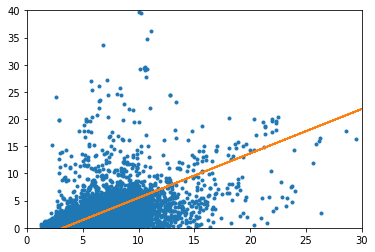

In [27]:
from numpy.polynomial.polynomial import polyfit

# Sample data
x = df.iloc[:, 0]
y = df.iloc[:, 1]

# Fit with polyfit
b, m = polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.xlim((0, 30))
plt.ylim((0, 40))
plt.show()


In [69]:
#Can out-of-bag estimates substitute for a separate test set??
from sklearn.ensemble import RandomForestRegressor
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, oob_score=True)

X = Concat_w_dummies_noNaN_noSpace_ri.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri['Usage']

rfmodel.fit(X, y);

oob_error = 1 - rfmodel.oob_score_

predictions = rfmodel.predict(X)
errors = abs(predictions - y)

#df of predictions, labels and errors
df = pd.DataFrame()
df['Usage_val'] = y
df['Predictions'] = predictions
df['errors'] = (list(errors))

#Probably not...oob error is VERY large. So training and testing on same dataset is not valid. (Although if I train and test on same set, then rsults are VERY good and capital is best predictor. Does this tell me anything??)

In [70]:
print(rfmodel.oob_score_)

feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)


0.0073301942645445095
                      importance
CAPITAL             1.367311e-01
LOCALE_13           7.437542e-02
SUBSCRIP-SUBSCRIPT  5.565417e-02
TOTEXPCO-TOTEXPCOL  5.068414e-02
REGBOR              5.024018e-02
AUDIO               4.914777e-02
PRMATEXP            2.725341e-02
KIDCIRCL            2.686670e-02
OTHPAID             2.641706e-02
TOTINCM             2.377192e-02
ELMATEXP            2.276568e-02
BENEFIT             2.183875e-02
PITUSR              2.169474e-02
OBEREG_5            2.039702e-02
STGVT               1.985700e-02
LOCGVT              1.837678e-02
TOTCIR              1.789077e-02
DUPLI-HRS_OPEN      1.655788e-02
TOTATTEN            1.541675e-02
REFERENC-REFERENCE  1.483072e-02
SALARIES            1.476569e-02
BKVOL               1.439537e-02
TOTPRO              1.388655e-02
LOANFM              1.243208e-02
GPTERMS             1.215968e-02
TOTPEMP-TOTSTAFF    1.194215e-02
KIDATTEN-KIDATTEND  1.073906e-02
OTHMATEX            1.054557e-02
OTHOPEXP            1

In [71]:
df

,Usage_val,Predictions,errors
0,2.599498,3.567564,0.968066
1,2.819901,3.584993,0.765092
2,4.281259,5.654689,1.373430
3,10.393033,10.226505,0.166527
4,51.981211,40.838581,11.142630
5,2.243814,2.925794,0.681980
6,33.072568,29.760851,3.311717
7,25.073156,23.963291,1.109865
8,7.351684,7.132296,0.219388
9,13.493803,13.505881,0.012078


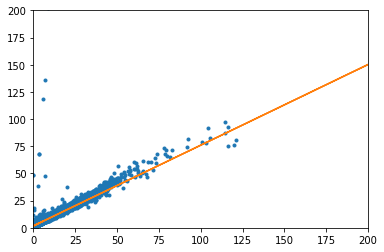

In [74]:
from numpy.polynomial.polynomial import polyfit

# Data
x = df.iloc[:, 0]
y = df.iloc[:, 1]

# Fit with polyfit
b, m = polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.xlim(0,200)
plt.ylim(0,200)
plt.show()

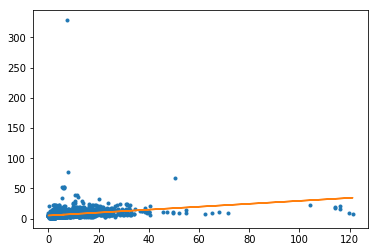

                         importance
CAPITAL                1.331595e-01
LOCALE_13              9.451080e-02
BENEFIT                5.801155e-02
REGBOR                 5.509837e-02
SUBSCRIP-SUBSCRIPT     4.637151e-02
ELMATEXP               4.487187e-02
AUDIO                  4.146635e-02
PRMATEXP               3.788724e-02
TOTEXPCO-TOTEXPCOL     3.656923e-02
KIDCIRCL               2.369410e-02
OBEREG_5               2.026521e-02
STGVT                  1.884379e-02
DUPLI-HRS_OPEN         1.796842e-02
OTHINCM                1.780910e-02
REFERENC-REFERENCE     1.776080e-02
TOTOPEXP-TOTOPEXP1     1.720554e-02
PITUSR                 1.699613e-02
BKVOL                  1.574703e-02
LOANTO                 1.561616e-02
TOTCIR                 1.450639e-02
TOTATTEN               1.447209e-02
TOTPRO                 1.192049e-02
VIDEO_PH               1.179986e-02
LOANFM                 1.177958e-02
KIDATTEN-KIDATTEND     1.105515e-02
OTHOPEXP               1.093797e-02
OTHPAID                1.016

In [81]:
#Go back to RF with SPECIFIC libraries removed.
from sklearn.ensemble import RandomForestRegressor
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42)

X = Concat_w_dummies_noNaN_noSpace_ri.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rfmodel.fit(X_train, y_train);

predictions = rfmodel.predict(X_test)

errors = abs(predictions - y_test)

#df of predictions, labels and errors
df = pd.DataFrame()
df['Usage_val'] = y_test
df['Predictions'] = predictions
df['errors'] = (list(errors))

# Data
x = df.iloc[:, 0]
y = df.iloc[:, 1]

# Fit with polyfit
b, m = polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

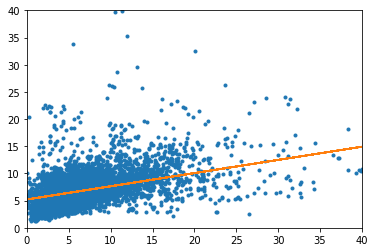

In [85]:
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.ylim(0, 40)
plt.xlim(0, 40)
plt.show()

In [191]:
df['Usage_bin'] = pd.qcut(df['Usage_val'], 4)
df['Predictions_bin'] = pd.qcut(df['Predictions'], 4)

df = df.reset_index(drop = True)
df['Usage_bin_val'] = ""
df['Predictions_bin_val'] = ""

Usage_bin_list = df['Usage_bin'].unique()
Predictions_bin_list = df['Predictions_bin'].unique()

for j in range(df.shape[0]):
    for i in range(4):
        if str(df.loc[j, 'Usage_bin']) == str(Usage_bin_list[i]):
            df.loc[j, 'Usage_bin_val'] = i+1 
        if str(df.loc[j, 'Predictions_bin']) == str(Predictions_bin_list[i]):
            df.loc[j, 'Predictions_bin_val'] = i+1 
                               

In [192]:
sum_equal = 0

for i in range(df.shape[0]):
    if df.loc[i, 'Usage_bin_val'] == df.loc[i, 'Predictions_bin_val']:
        sum_equal = sum_equal+1
print(sum_equal, df.shape[0])

2080 7290


In [193]:
df["Difference"] = abs(df['Usage_bin_val'] - df['Predictions_bin_val'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a5a5b2c18>]],
      dtype=object)

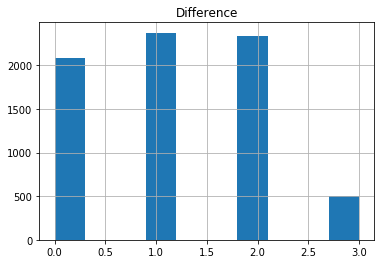

In [194]:
df.hist(column='Difference')

In [189]:
df['error_pct'] = df['errors']/df['Usage_val']

sum_error = 0

for i in range(df.shape[0]):
    if df.loc[i, 'error_pct'] <= .3:
        sum_error = sum_error + 1
print(sum_error, df.shape[0])

3395 7290


In [190]:
df

,Usage_val,Predictions,errors,Usage_bin,Predictions_bin,Usage_bin_val,Predictions_bin_val,Difference,error_pct
0,6.022878,3.057549,2.965329,"(3.881, 6.82]","(1.2240000000000002, 5.348]",1,1,0,0.492344
1,5.585838,3.001737,2.584102,"(3.881, 6.82]","(1.2240000000000002, 5.348]",1,1,0,0.462617
2,5.241019,2.965093,2.275926,"(3.881, 6.82]","(1.2240000000000002, 5.348]",1,1,0,0.434252
3,5.192759,2.939525,2.253233,"(3.881, 6.82]","(1.2240000000000002, 5.348]",1,1,0,0.433918
4,5.104385,3.025773,2.078612,"(3.881, 6.82]","(1.2240000000000002, 5.348]",1,1,0,0.407221
5,4.996898,3.231557,1.765341,"(3.881, 6.82]","(1.2240000000000002, 5.348]",1,1,0,0.353287
6,3.827057,7.065589,3.238532,"(-0.001, 3.881]","(5.348, 7.379]",2,2,0,0.846220
7,4.211581,6.458527,2.246947,"(3.881, 6.82]","(5.348, 7.379]",1,2,1,0.533516
8,4.273914,7.390988,3.117074,"(3.881, 6.82]","(7.379, 328.472]",1,3,2,0.729325
9,3.501529,6.121883,2.620353,"(-0.001, 3.881]","(5.348, 7.379]",2,2,0,0.748345


In [195]:
print(feature_importances)

                         importance
CAPITAL                1.331595e-01
LOCALE_13              9.451080e-02
BENEFIT                5.801155e-02
REGBOR                 5.509837e-02
SUBSCRIP-SUBSCRIPT     4.637151e-02
ELMATEXP               4.487187e-02
AUDIO                  4.146635e-02
PRMATEXP               3.788724e-02
TOTEXPCO-TOTEXPCOL     3.656923e-02
KIDCIRCL               2.369410e-02
OBEREG_5               2.026521e-02
STGVT                  1.884379e-02
DUPLI-HRS_OPEN         1.796842e-02
OTHINCM                1.780910e-02
REFERENC-REFERENCE     1.776080e-02
TOTOPEXP-TOTOPEXP1     1.720554e-02
PITUSR                 1.699613e-02
BKVOL                  1.574703e-02
LOANTO                 1.561616e-02
TOTCIR                 1.450639e-02
TOTATTEN               1.447209e-02
TOTPRO                 1.192049e-02
VIDEO_PH               1.179986e-02
LOANFM                 1.177958e-02
KIDATTEN-KIDATTEND     1.105515e-02
OTHOPEXP               1.093797e-02
OTHPAID                1.016

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a74d5cdd8>]],
      dtype=object)

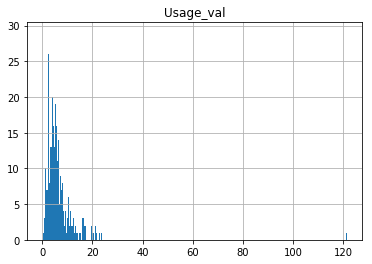

In [200]:
df.hist(column='Usage_val', bins = len(df['Usage_val'].unique()))

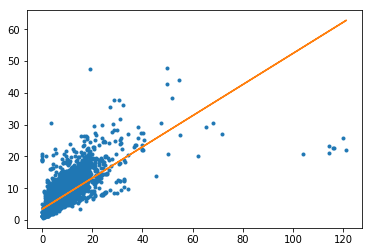

                         importance
POPU-POPU_LSA          3.952130e-01
TOTCIR                 6.192995e-02
PITUSR                 5.788665e-02
OTHPAID                3.869004e-02
REFERENC-REFERENCE     2.787504e-02
TOTPEMP-TOTSTAFF       2.706552e-02
TOTATTEN               2.573939e-02
REGBOR                 2.425839e-02
ELMATEXP               2.376297e-02
TOTINCM                2.226089e-02
TOTOPEXP-TOTOPEXP1     1.981906e-02
AUDIO                  1.779398e-02
VIDEO_PH               1.777587e-02
LOCGVT                 1.653774e-02
TOTPRO                 1.630229e-02
SALARIES               1.602597e-02
STAFFEXP-TOTEXP        1.334139e-02
TOTEXPCO-TOTEXPCOL     1.303196e-02
STGVT                  1.211658e-02
LOANFM                 1.196221e-02
OBEREG_5               1.111736e-02
CAPITAL                1.001247e-02
BENEFIT                9.787035e-03
PRMATEXP               8.304613e-03
OTHOPEXP               8.049132e-03
SUBSCRIP-SUBSCRIPT     7.954072e-03
OTHMATEX               7.620

In [201]:
#RF with SPECIFIC libraries removed, but POPU-POPU_LSA kept in.
from sklearn.ensemble import RandomForestRegressor
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42)

X = Concat_w_dummies_noNaN_noSpace_ri.drop(columns = ['Usage'])
y = Concat_w_dummies_noNaN_noSpace_ri['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rfmodel.fit(X_train, y_train);

predictions = rfmodel.predict(X_test)

errors = abs(predictions - y_test)

#df of predictions, labels and errors
df = pd.DataFrame()
df['Usage_val'] = y_test
df['Predictions'] = predictions
df['errors'] = (list(errors))

# Data
x = df.iloc[:, 0]
y = df.iloc[:, 1]

# Fit with polyfit
b, m = polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#If I put back population, it looks like prediction improves a lot. BUT that's super unfair and I won't actually get anything meaningful out of it. 

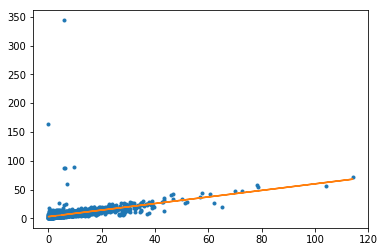

                      importance
CAPITAL             1.550223e-01
LOCALE_13           6.208908e-02
SUBSCRIP-SUBSCRIPT  5.097266e-02
LOCGVT              5.086722e-02
AUDIO               4.907937e-02
REGBOR              4.835682e-02
ELMATEXP            3.324973e-02
BENEFIT             2.782137e-02
PRMATEXP            2.653423e-02
OTHPAID             2.520832e-02
KIDCIRCL            2.473627e-02
TOTEXPCO-TOTEXPCOL  2.132186e-02
OBEREG_5            1.986258e-02
TOTINCM             1.947581e-02
STGVT               1.787335e-02
PITUSR              1.750187e-02
TOTATTEN            1.720726e-02
BKVOL               1.549325e-02
SALARIES            1.515080e-02
LOANFM              1.479849e-02
TOTCIR              1.349094e-02
TOTPRO              1.308631e-02
VIDEO_PH            1.246161e-02
TOTOPEXP-TOTOPEXP1  1.232549e-02
STAFFEXP-TOTEXP     1.187764e-02
REFERENC-REFERENCE  1.184284e-02
DUPLI-HRS_OPEN      1.118587e-02
LOANTO              1.089247e-02
OTHMATEX            1.020130e-02
OTHINCM   

In [202]:
#Next, try RF with train and test set (without removing specific libraries)

#RF with SPECIFIC libraries removed, but POPU-POPU_LSA kept in.
from sklearn.ensemble import RandomForestRegressor
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42)

X = Concat_w_dummies_noNaN_noSpace_ri.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri['Usage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rfmodel.fit(X_train, y_train);
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)

#df of predictions, labels and errors
df = pd.DataFrame()
df['Usage_val'] = y_test
df['Predictions'] = predictions
df['errors'] = (list(errors))

# Data
x = df.iloc[:, 0]
y = df.iloc[:, 1]

# Fit with polyfit
b, m = polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

In [203]:
df

,Usage_val,Predictions,errors
25239,5.056924,5.482237,0.425312
20235,5.106077,5.858608,0.752531
33348,12.106742,9.690728,2.416013
34396,4.641912,6.373080,1.731168
335,3.147126,5.284222,2.137096
22244,7.988672,6.819250,1.169423
20830,6.227848,8.108614,1.880766
36032,2.016359,3.142483,1.126124
19383,10.041637,8.872891,1.168745
32493,5.803632,12.621422,6.817790


In [210]:
df = df.reset_index(drop = True)
df['error_pct'] = df['errors']/df['Usage_val']

sum_error = 0

for i in range(df.shape[0]):
    if df.loc[i, 'error_pct'] <= .35:
        sum_error = sum_error + 1
#print(sum_error, df.shape[0])

4977 7334


In [217]:
#Get rid of usage 0 to get mean error
df[df['Usage_val'] == 0].index

Int64Index([3336, 4069], dtype='int64')

In [218]:
df = df.drop(df[df['Usage_val'] == 0].index)

In [219]:
df['error_pct'].mean()

1.8066626020979724

In [221]:
list(df['error_pct'])

[0.08410497539313212,
 0.14737953343818117,
 0.19955931673223432,
 0.37294293465041084,
 0.6790626924705169,
 0.14638509112997086,
 0.3019928346635111,
 0.5584940209951661,
 0.11638991649618709,
 1.1747452968495584,
 0.4722303463474442,
 0.17529741467371426,
 0.2859378860393762,
 1.1019257469754948,
 0.007444995827738326,
 0.34307808731775985,
 0.1638648963528337,
 0.10035567137269603,
 0.011896765045361773,
 0.16198927494973173,
 0.6974776312687375,
 1.4120924393874277,
 0.35283548480827853,
 0.19875259700758635,
 0.2140749831598252,
 0.19661550324689545,
 0.07005786633561113,
 0.0975962154019982,
 0.0823294531633589,
 0.36405057727828916,
 0.158756415825665,
 0.012849255003076555,
 0.25545161585230775,
 0.5878554038885679,
 1.2436545309409053,
 0.7970630807332406,
 0.24423369775799425,
 0.32884588548417,
 0.2088568870936357,
 0.025530979201600135,
 0.11893287072050762,
 0.13458494663423196,
 3.842070214855385,
 0.16317300484033,
 0.32354402228464,
 0.486654715532893,
 0.0727208346335

In [222]:
df['error_pct'].max()

8180.871706734663

In [223]:
df[df['error_pct'] > 8000].index

Int64Index([3502], dtype='int64')

In [225]:
df.loc[3502, :]

Usage_val         0.020021
Predictions     163.807362
errors          163.787341
error_pct      8180.871707
Name: 3502, dtype: float64

## After 2:30 standup

### I should run the model the right way. Take 20% of libraries out first!

In [227]:
###GET random set of libraries to remove
UniqueFSCS = set(Location_Detail_DF_noNaN_noSpace_ri.loc[:, 'FSCSKEY'].tolist())
print(len(UniqueFSCS))

#Pick 20% of FSCSKEYS randomly
Numb_to_sel = int((.20*len(UniqueFSCS)))
_20PctFSCSList = random.sample(UniqueFSCS, Numb_to_sel)

#Get index of these FSCSKEYS from Location_Detail_DF_noNaN_noSpace_ri
Indexlist = list()
for FSCSkey in _20PctFSCSList:
    Indexfor_20PctFSCSList = Location_Detail_DF_noNaN_noSpace_ri[Location_Detail_DF_noNaN_noSpace_ri.FSCSKEY == FSCSkey].index
    Indexlist.append(list(Indexfor_20PctFSCSList))
flattened_Indexlist = [val for sublist in Indexlist for val in sublist]
print(len(flattened_Indexlist))

6303
7375


                         importance
REGBOR                 5.628639e-02
PITUSR                 4.384555e-02
OBEREG_5               4.334826e-02
STGVT                  4.243938e-02
TOTPRO                 3.340035e-02
KIDCIRCL               3.115339e-02
BKVOL                  2.981261e-02
DUPLI-HRS_OPEN         2.800924e-02
TOTATTEN               2.629899e-02
SUBSCRIP-SUBSCRIPT     2.609754e-02
REFERENC-REFERENCE     2.423273e-02
OTHPAID                2.422588e-02
TOTINCM                2.272097e-02
KIDATTEN-KIDATTEND     2.147530e-02
OTHINCM                2.086199e-02
LOANFM                 2.084167e-02
TOTCIR                 2.071780e-02
OTHMATEX               1.886587e-02
LOCGVT                 1.831579e-02
GPTERMS                1.806991e-02
LOANTO                 1.732448e-02
VIDEO_PH               1.613013e-02
BRANLIB                1.559553e-02
TOTEXPCO-TOTEXPCOL     1.416085e-02
LIBRARIAN-LIBRARIA     1.392000e-02
OTHOPEXP               1.366438e-02
STABR_TX               1.360

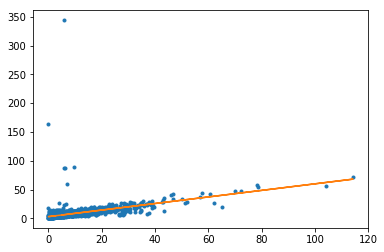

In [228]:
#RF with SPECIFIC libraries removed, but POPU-POPU_LSA kept in.
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42)

X = Concat_w_dummies_noNaN_noSpace_ri.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df.iloc[:, 0]
y = df.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

In [229]:
print(rfmodel.score(X_test, y_test))
print(rfmodel.score(X_train, y_train))

0.015304176408580618
0.960147484911178


In [237]:
print(df_TEST['errors'].max())
print(df_TRAIN['errors'].max())
idx = df_TEST[df_TEST['errors'] > 1600].index
print(idx)
df_TEST.loc[33595, :]

1602.8691621157075
33.63604596772885
Int64Index([33595], dtype='int64')


Usage_val      1611.105263
Predictions       8.236101
errors         1602.869162
Name: 33595, dtype: float64

In [241]:
y_test.max()

1611.1052631578948

### Take out usage outliers! (As shown above, there are definitely some!)

In [246]:
print(Location_Detail_DF_noNaN_noSpace_ri.shape)
print(Concat_w_dummies_noNaN_noSpace_ri.shape)

(36669, 6)
(36669, 160)


In [255]:
#Remove anything 5SD's higher than mean?
mean_plus_5xSD = Concat_w_dummies_noNaN_noSpace_ri.Usage.mean() + 5*Concat_w_dummies_noNaN_noSpace_ri.Usage.std()
OutlierIdx = Concat_w_dummies_noNaN_noSpace_ri[Concat_w_dummies_noNaN_noSpace_ri.Usage > mean_plus_5xSD].index
Concat_w_dummies_noNaN_noSpace_ri.loc[OutlierIdx, ['Usage']]



,Usage
259,67.936658
1118,60.954139
2244,79.154102
2452,65.284537
2766,103.314860
3308,100.717874
5638,61.868360
6332,65.004515
6841,79.559867
7368,105.378260


In [256]:
#Actually, for starters let's simply remove row 33595, with usage >1600
Location_Detail_DF_noNaN_noSpace_ri_1611dropped = Location_Detail_DF_noNaN_noSpace_ri.drop([33595])
Concat_w_dummies_noNaN_noSpace_ri_1611dropped = Concat_w_dummies_noNaN_noSpace_ri.drop([33595])

Location_Detail_DF_noNaN_noSpace_ri_1611dropped = Location_Detail_DF_noNaN_noSpace_ri_1611dropped.reset_index(drop = True)
Concat_w_dummies_noNaN_noSpace_ri_1611dropped = Concat_w_dummies_noNaN_noSpace_ri_1611dropped.reset_index(drop = True)



In [291]:
###GET random set of libraries to remove
UniqueFSCS = set(Location_Detail_DF_noNaN_noSpace_ri_1611dropped.loc[:, 'FSCSKEY'].tolist())
print(len(UniqueFSCS))

#Pick 20% of FSCSKEYS randomly
Numb_to_sel = int((.20*len(UniqueFSCS)))
_20PctFSCSList = random.sample(UniqueFSCS, Numb_to_sel)

#Get index of these FSCSKEYS from Location_Detail_DF_noNaN_noSpace_ri
Indexlist = list()
for FSCSkey in _20PctFSCSList:
    Indexfor_20PctFSCSList = Location_Detail_DF_noNaN_noSpace_ri_1611dropped[Location_Detail_DF_noNaN_noSpace_ri_1611dropped.FSCSKEY == FSCSkey].index
    Indexlist.append(list(Indexfor_20PctFSCSList))
flattened_Indexlist = [val for sublist in Indexlist for val in sublist]
print(len(flattened_Indexlist))

6303
7302


                         importance
REGBOR                 5.266063e-02
OBEREG_5               4.440276e-02
PITUSR                 4.432163e-02
KIDCIRCL               4.101984e-02
BKVOL                  3.704511e-02
STGVT                  3.035674e-02
TOTPRO                 2.868562e-02
SUBSCRIP-SUBSCRIPT     2.738277e-02
OTHPAID                2.698222e-02
TOTATTEN               2.671143e-02
REFERENC-REFERENCE     2.598841e-02
TOTCIR                 2.557527e-02
DUPLI-HRS_OPEN         2.307483e-02
TOTINCM                2.199734e-02
OTHMATEX               2.125868e-02
OTHINCM                1.965006e-02
GPTERMS                1.942802e-02
LOCGVT                 1.905744e-02
LOANFM                 1.889193e-02
VIDEO_PH               1.880914e-02
OTHOPEXP               1.705441e-02
BRANLIB                1.699361e-02
KIDATTEN-KIDATTEND     1.622772e-02
YAATTEN                1.591017e-02
LIBRARIAN-LIBRARIA     1.563662e-02
LOANTO                 1.354015e-02
STABR_TX               1.338

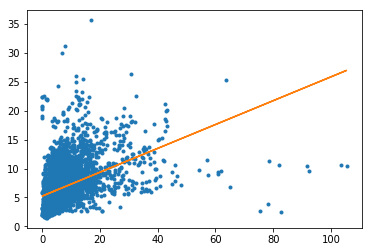

Score for Test set:  0.18987926162923574
Score for Train set:  0.9594997200071897


In [292]:
#RF with SPECIFIC libraries removed (and POPU-POPU_LSA removed too). [Single outlier dropped]
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42)

X = Concat_w_dummies_noNaN_noSpace_ri_1611dropped.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri_1611dropped['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

In [295]:
print(df_TEST['errors'].max())
print(df_TRAIN['errors'].max())

94.86109870931404
31.114413410691085


In [ ]:
#take out outliers!!
#plot correlation map
#email Jolene

In [296]:
df_TEST.loc[df_TEST[df_TEST['errors'] > 90].index, :]

,Usage_val,Predictions,errors
2766,103.31486,10.625884,92.688976
7368,105.37826,10.517162,94.861099


In [299]:
FSCSKeys_Used_Above_Jan28_535pm = _20PctFSCSList

In [301]:
#Now, try to remove anything 5SD's higher than mean.
Concat_w_dummies_noNaN_noSpace_ri = Concat_w_dummies_noNaN_noSpace_ri.reset_index(drop = True)
Location_Detail_DF_noNaN_noSpace_ri = Location_Detail_DF_noNaN_noSpace_ri.reset_index(drop = True)

mean_plus_5xSD = Concat_w_dummies_noNaN_noSpace_ri.Usage.mean() + 5*Concat_w_dummies_noNaN_noSpace_ri.Usage.std()
OutlierIdx = Concat_w_dummies_noNaN_noSpace_ri[Concat_w_dummies_noNaN_noSpace_ri.Usage > mean_plus_5xSD].index
print("Number of outliers:", Concat_w_dummies_noNaN_noSpace_ri.loc[OutlierIdx, ['Usage']].shape[0])
      
Concat_w_dummies_noNaN_noSpace_ri_DropOutliers=Concat_w_dummies_noNaN_noSpace_ri.drop(OutlierIdx)
Location_Detail_DF_noNaN_noSpace_ri_DropOutliers=Location_Detail_DF_noNaN_noSpace_ri.drop(OutlierIdx)

print(Concat_w_dummies_noNaN_noSpace_ri.shape, Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.shape)
print(Location_Detail_DF_noNaN_noSpace_ri.shape, Location_Detail_DF_noNaN_noSpace_ri_DropOutliers.shape)

Number of outliers: 43
(36669, 160) (36626, 160)
(36669, 6) (36626, 6)


In [304]:
###GET random set of libraries to remove
Location_Detail_DF_noNaN_noSpace_ri_DropOutliers = Location_Detail_DF_noNaN_noSpace_ri_DropOutliers.reset_index(drop=True)
Concat_w_dummies_noNaN_noSpace_ri_DropOutliers = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.reset_index(drop=True)

UniqueFSCS = set(Location_Detail_DF_noNaN_noSpace_ri_DropOutliers.loc[:, 'FSCSKEY'].tolist())
print(len(UniqueFSCS))

#Pick 20% of FSCSKEYS randomly
Numb_to_sel = int((.20*len(UniqueFSCS)))
_20PctFSCSList = random.sample(UniqueFSCS, Numb_to_sel)

#Get index of these FSCSKEYS from Location_Detail_DF_noNaN_noSpace_ri
Indexlist = list()
for FSCSkey in _20PctFSCSList:
    Indexfor_20PctFSCSList = Location_Detail_DF_noNaN_noSpace_ri_DropOutliers[Location_Detail_DF_noNaN_noSpace_ri_DropOutliers.FSCSKEY == FSCSkey].index
    Indexlist.append(list(Indexfor_20PctFSCSList))
flattened_Indexlist = [val for sublist in Indexlist for val in sublist]
print(len(flattened_Indexlist))

6300
7399


                      importance
REGBOR              6.797741e-02
OBEREG_5            4.979923e-02
PITUSR              4.038667e-02
STGVT               3.155894e-02
DUPLI-HRS_OPEN      2.984744e-02
TOTCIR              2.977937e-02
TOTATTEN            2.974423e-02
BKVOL               2.846290e-02
SUBSCRIP-SUBSCRIPT  2.794896e-02
REFERENC-REFERENCE  2.792363e-02
VIDEO_PH            2.569815e-02
TOTPRO              2.566782e-02
OTHINCM             2.344859e-02
KIDCIRCL            2.080489e-02
LOANFM              1.995267e-02
OTHPAID             1.985876e-02
OTHMATEX            1.942112e-02
LOCGVT              1.913825e-02
GPTERMS             1.765047e-02
KIDATTEN-KIDATTEND  1.736491e-02
BRANLIB             1.650170e-02
OTHOPEXP            1.633732e-02
LOANTO              1.509470e-02
LIBRARIAN-LIBRARIA  1.501060e-02
TOTPEMP-TOTSTAFF    1.394916e-02
BENEFIT             1.347782e-02
KIDPRO              1.291401e-02
PRMATEXP            1.277521e-02
TOTOPEXP-TOTOPEXP1  1.266149e-02
STABR_TX  

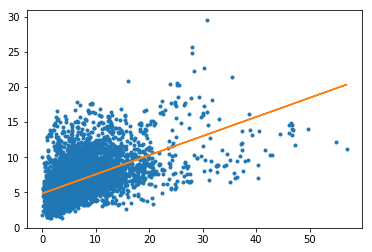

Score for Test set:  0.2752199609208734
Score for Train set:  0.9619547673223444


In [308]:
#RF with SPECIFIC libraries removed (and POPU-POPU_LSA removed too).
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42)

X = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

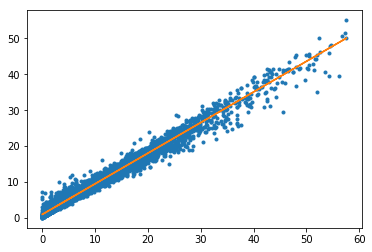

In [314]:
#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TRAIN.iloc[:, 0]
y = df_TRAIN.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

In [315]:
FSCSKeys_Used_Above_Jan28_550pm = _20PctFSCSList

In [321]:
df_TEST['error_pct'] = df_TEST['errors']/df_TEST['Usage_val']

sum_error = 0

df_TEST = df_TEST.reset_index(drop = True)

for i in range(df_TEST.shape[0]):
    if df_TEST.loc[i, 'error_pct'] <= .5:
        sum_error = sum_error + 1
print(sum_error, df.shape[0])

4709 7332


## Try to reduce overfitting in RFM

                      importance
REGBOR              6.815029e-02
OBEREG_5            4.979316e-02
PITUSR              4.066495e-02
STGVT               3.088941e-02
TOTATTEN            3.018111e-02
DUPLI-HRS_OPEN      2.992937e-02
TOTCIR              2.891611e-02
SUBSCRIP-SUBSCRIPT  2.845347e-02
BKVOL               2.759535e-02
REFERENC-REFERENCE  2.739530e-02
VIDEO_PH            2.613083e-02
TOTPRO              2.527658e-02
OTHINCM             2.395465e-02
OTHPAID             2.093945e-02
KIDCIRCL            2.047491e-02
OTHMATEX            2.003971e-02
LOCGVT              1.991073e-02
LOANFM              1.977627e-02
GPTERMS             1.845491e-02
KIDATTEN-KIDATTEND  1.776552e-02
BRANLIB             1.660314e-02
OTHOPEXP            1.588973e-02
LIBRARIAN-LIBRARIA  1.528910e-02
LOANTO              1.490320e-02
TOTPEMP-TOTSTAFF    1.407128e-02
PRMATEXP            1.316275e-02
BENEFIT             1.303756e-02
KIDPRO              1.291394e-02
TOTOPEXP-TOTOPEXP1  1.271782e-02
TOTEXPCO-T

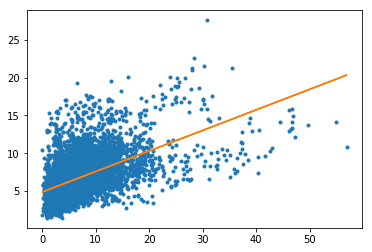

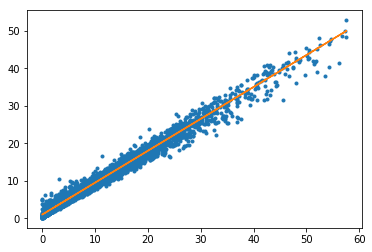

Score for Test set:  0.2755449636245123
Score for Train set:  0.9644090036794207


In [323]:
### #1. Increase number of trees 10-fold
#RF with SPECIFIC libraries removed (and POPU-POPU_LSA removed too).
rfmodel = RandomForestRegressor(n_estimators = 1000, random_state = 42)

X = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

#Plot df_TRAIN Usage vs. Prediction:
# Data
x = df_TRAIN.iloc[:, 0]
y = df_TRAIN.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

#Increasing estimators to 1000 did not do anything!
#This is good to know. Took a while to run, so reduce back to 100 trees.

                      importance
REGBOR              4.230813e-02
DUPLI-HRS_OPEN      3.196973e-02
STGVT               2.778797e-02
PITUSR              2.744856e-02
BKVOL               2.595741e-02
TOTCIR              2.476825e-02
SUBSCRIP-SUBSCRIPT  2.457306e-02
TOTATTEN            2.417151e-02
VIDEO_PH            2.361373e-02
REFERENC-REFERENCE  2.350215e-02
KIDCIRCL            2.322685e-02
LOANFM              2.251820e-02
TOTPRO              2.245906e-02
LOANTO              2.151000e-02
LOCGVT              2.108208e-02
OTHPAID             2.053756e-02
OTHINCM             1.993890e-02
VIDEO               1.984816e-02
STAFFEXP-TOTEXP     1.926496e-02
TOTOPEXP-TOTOPEXP1  1.923157e-02
SALARIES            1.920060e-02
TOTPEMP-TOTSTAFF    1.912276e-02
OTHMATEX            1.838125e-02
KIDATTEN-KIDATTEND  1.822764e-02
OTHOPEXP            1.809510e-02
TOTINCM             1.802894e-02
TOTEXPCO-TOTEXPCOL  1.782783e-02
KIDPRO              1.739738e-02
BENEFIT             1.735312e-02
AUDIO     

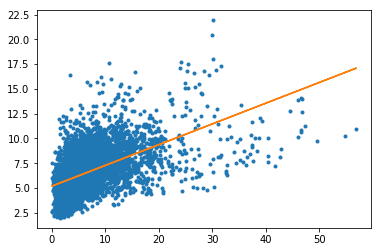

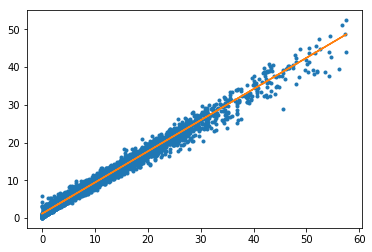

Score for Test set:  0.254203848006636
Score for Train set:  0.9570872919751309


In [324]:
### #2. Reduce number of trees back to 100. Reduce max_features from auto (total features) to sqrt (sqrt(features))
#RF with SPECIFIC libraries removed (and POPU-POPU_LSA removed too).
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, max_features = "sqrt")

X = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

#Plot df_TRAIN Usage vs. Prediction:
# Data
x = df_TRAIN.iloc[:, 0]
y = df_TRAIN.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

#Doesn't really change much.

                      importance
OBEREG_5            1.135773e-01
REGBOR              8.318103e-02
PITUSR              3.863340e-02
VIDEO_PH            3.544094e-02
BRANLIB             3.480351e-02
TOTATTEN            3.441755e-02
TOTPRO              3.368625e-02
STGVT               3.276750e-02
TOTCIR              2.978424e-02
STABR_TX            2.841421e-02
DUPLI-HRS_OPEN      2.597621e-02
SUBSCRIP-SUBSCRIPT  2.570061e-02
BKVOL               2.259665e-02
REFERENC-REFERENCE  2.010757e-02
GEOCODE_CI1         1.867753e-02
LOCGVT              1.787182e-02
OTHINCM             1.579204e-02
LOCALE_43           1.463650e-02
OTHPAID             1.435622e-02
KIDATTEN-KIDATTEND  1.422661e-02
OTHMATEX            1.403949e-02
KIDCIRCL            1.347631e-02
VIDEO_DL            1.243534e-02
STABR_MA            1.233650e-02
GPTERMS             1.207539e-02
STABR_AK            1.176009e-02
TOTOPEXP-TOTOPEXP1  1.155990e-02
LOANFM              1.155502e-02
STABR_NE            1.034473e-02
LOCALE_43 

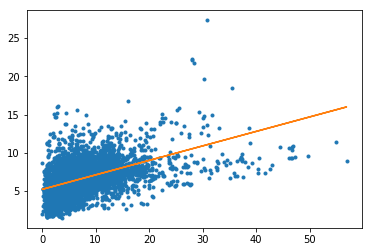

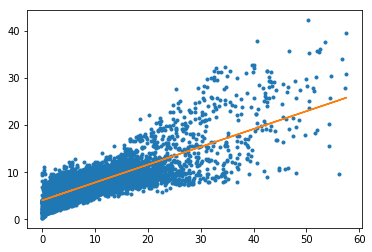

Score for Test set:  0.2130160969912255
Score for Train set:  0.5038187933042543


In [325]:
### #3. Reduce number of trees back to 100. Change max_features back to auto (total features). Reduce max_depth to 10 (this is a bit arbitrary and pretty low; can consider increasing).
#RF with SPECIFIC libraries removed (and POPU-POPU_LSA removed too).
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth = 10)

X = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = Concat_w_dummies_noNaN_noSpace_ri_DropOutliers['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

#Plot df_TRAIN Usage vs. Prediction:
# Data
x = df_TRAIN.iloc[:, 0]
y = df_TRAIN.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

#Train set is worse, but test set is no better.

In [ ]:
#n_estimators = 100
#max_features = 30-50% of the number of features (reducing may reduce overfitting; right now, it's # of features)

#max_depth, min_samples_leaf

#NEXT:
#max_features to sqrt (sqrt(features)), max_depth to decrease